In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import plotly.express as px

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, accuracy_score
from nltk.stem import PorterStemmer
from sklearn.model_selection import GridSearchCV, train_test_split
stemmer = PorterStemmer()
try:
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
except:
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    stop_words = set(ENGLISH_STOP_WORDS)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def load_and_inspect(filepath):
    df = pd.read_csv(filepath)
    
    print("Dataset Shape:", df.shape)
    print("Class Distribution:\n", df['class'].value_counts())
    return df

# --- 2. Text Cleaning & Preprocessing ---
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'rt\s', '', text)               # Remove 'RT'
    text = re.sub(r'@\w+', '', text)               # Remove mentions
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub(r'&#[0-9]+;', '', text)          # Remove HTML entities
    text = re.sub(r'[^\w\s]', '', text)            # Remove punctuation
    text = re.sub(r'\d+', '', text)                # Remove numbers
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    return " ".join(filtered_tokens)

def preprocess_data(df):
    # Apply cleaning
    df['clean_text'] = df['tweet'].apply(clean_text)
    # Tokenization & Stopword Removal
    df['tokens'] = df['clean_text'].apply(lambda x: [
        word for word in x.split() if word not in stop_words and len(word) > 2
    ])
    df['processed_text'] = df['tokens'].apply(lambda x: ' '.join(x))
    
    # Map classes
    label_mapping = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}
    df['label_desc'] = df['class'].map(label_mapping)

    return df

def add_features(df):
    # Structural Features
    df['word_count'] = df['tokens'].apply(len)
    df['char_count'] = df['clean_text'].apply(len)
    
    # Sentiment Analysis
    df['sentiment'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
    return df

# Note: You should already have 'df' loaded with 'processed_text' and 'label_desc' columns.

def plot_pca_3d_interactive(df):
    """
    Performs 3D PCA on TF-IDF vectors of text data and displays an 
    interactive 3D scatter plot using Plotly Express.
    
    Assumes df has 'processed_text' (text data) and 'label_desc' (label).
    """
    
    # 1. Sample for performance (Max 5000 samples for better interactivity)
    sample_size = min(500, len(df))
    subset, _ = train_test_split(
        df, 
        train_size=sample_size, 
        stratify=df['class'], 
        random_state=42
    )
    
    # 2. TF-IDF Vectorization
    tfidf = TfidfVectorizer(max_features=1000)
    X = tfidf.fit_transform(subset['processed_text'].values).toarray()
    
    # 2. TF-IDF Vectorization
    tfidf = TfidfVectorizer(max_features=1000)
    # Using .values ensures we get the array structure required for fit_transform
    X = tfidf.fit_transform(subset['processed_text'].values).toarray()
    
    # 3. 3D PCA Transformation
    # Change n_components from 2 to 3
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X)
    
    # 4. Create DataFrame for Plotting
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
    pca_df['label'] = subset['label_desc'].values
    
    # 5. Interactive 3D Plot using Plotly Express
    
    # Calculate explained variance for the title
    explained_variance = pca.explained_variance_ratio_
    
    # Create the interactive 3D plot
    fig = px.scatter_3d(
        pca_df, 
        x='PC1', 
        y='PC2', 
        z='PC3',
        color='label',             # Color points by the label
        opacity=0.8,
        title='3D PCA of TF-IDF Vectors (Interactive)',
        labels={
            'PC1': f'PC1 ({explained_variance[0]:.2f} explained)',
            'PC2': f'PC2 ({explained_variance[1]:.2f} explained)',
            'PC3': f'PC3 ({explained_variance[2]:.2f} explained)'
        }
    )
    
    # Set the marker size and style
    fig.update_traces(marker=dict(size=5, line=dict(width=0.5, color='DarkSlateGrey')))
    
    # Display the interactive plot
    fig.show()

In [3]:
df = load_and_inspect('/kaggle/input/sentiment-analysis-twitter-hate-speech/train.csv')
df_test = load_and_inspect('/kaggle/input/sentiment-analysis-twitter-hate-speech/test.csv')
df = preprocess_data(df)
df_test = preprocess_data(df_test)
df_clean = df.copy()
df_clean = df_clean.drop(['tokens', 'processed_text', 'count', 'neither_count', 'hate_speech_count', 'offensive_language_count', 'tweet'], axis = 1)
df = add_features(df)
df_test = add_features(df_test)

Dataset Shape: (19826, 6)
Class Distribution:
 class
1    15352
2     3330
0     1144
Name: count, dtype: int64
Dataset Shape: (4957, 6)
Class Distribution:
 class
1    3838
2     833
0     286
Name: count, dtype: int64


In [4]:
hate_speech_df = df.loc[df['class'] == 0, 'clean_text']
hate_speech_df.to_csv('hate_speech.csv')
hate_speech_df.head(10)

23                                                faggot
48     coons monkeys like disgust minstrel show negro...
63     town movie friends stabbed nig times got sent ...
73     people time aryan race stand say mongerls turn...
75                               fuuck jalens slow bitch
135    racial minorities werent criminally inclined w...
168                               ha ha ha good fat dyke
174                        bitch youre ugliest cunt ever
182                   hell blk stop sayin nigger america
278                       cant trust niggas come bitches
Name: clean_text, dtype: object

In [5]:
# plot_pca_3d_interactive(df)

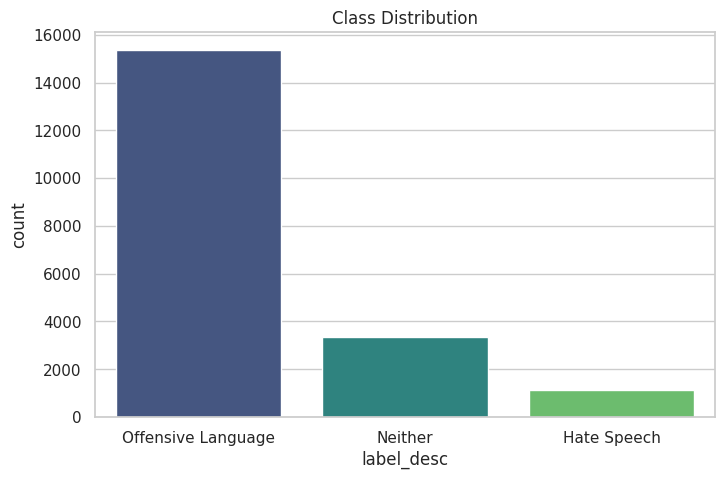

In [6]:
sns.set(style="whitegrid")
    
# A. Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label_desc', data=df, palette='viridis', 
              order=df['label_desc'].value_counts().index)
plt.title('Class Distribution')
plt.savefig("class_distribution.png")
plt.show()

## Class Imbalance:
The dataset is heavily imbalanced. Offensive Language (Class 1) makes up ~77% of the data, while Hate Speech (Class 0) is the minority at ~6%. This suggests a model trained on this data might struggle to distinguish "Hate" from "Offensive" without techniques like oversampling or class weighting.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

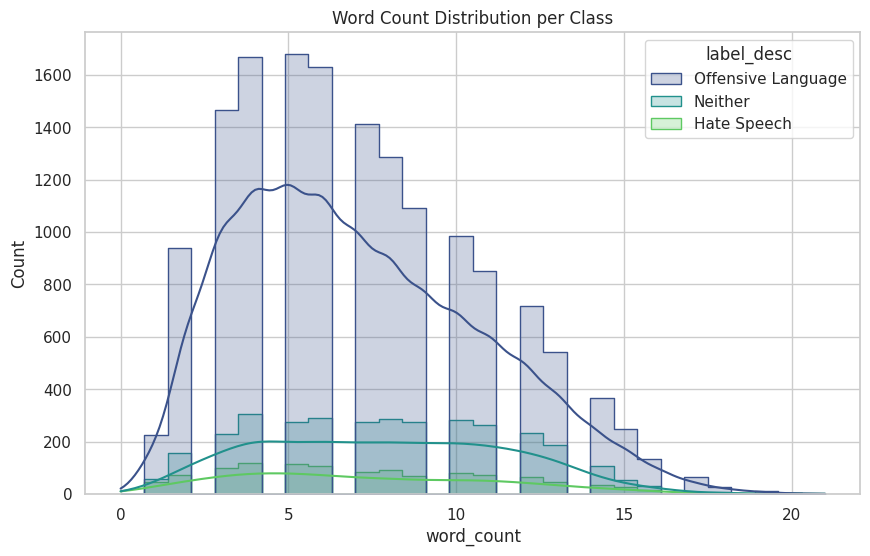

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='label_desc', kde=True, 
             palette='viridis', element="step", bins=30)
plt.title('Word Count Distribution per Class')
plt.savefig('word_count_distribution.png')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


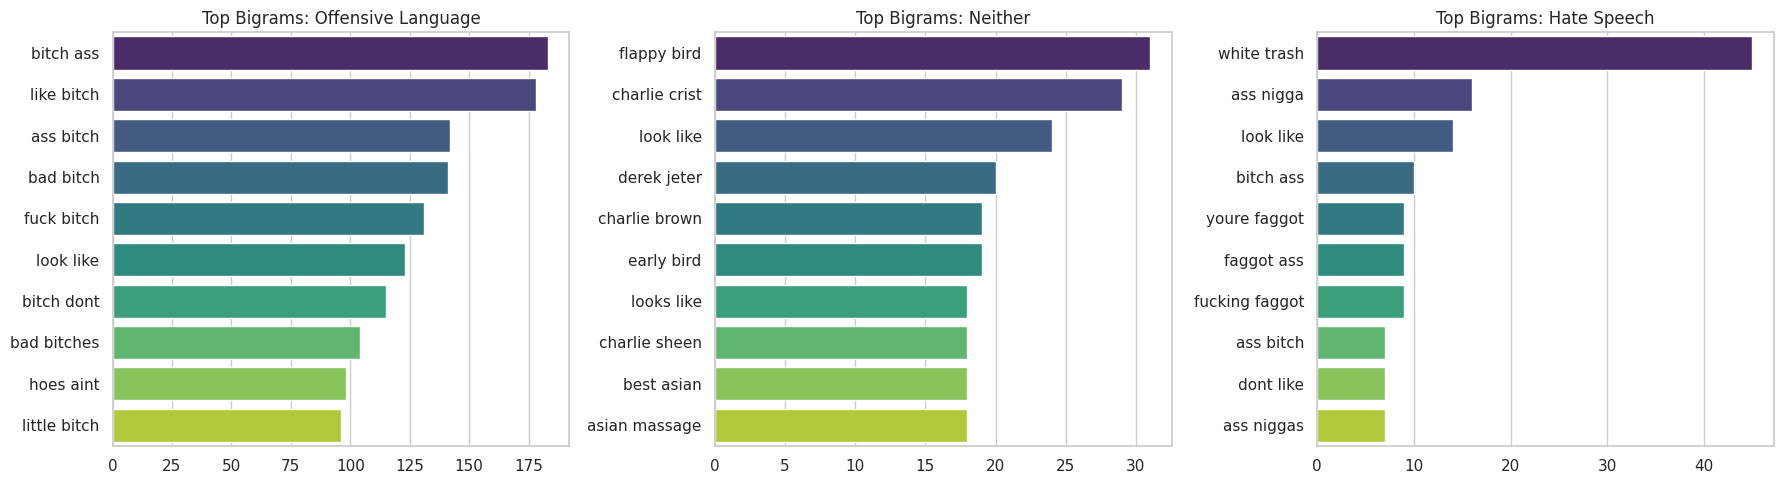

In [8]:
def get_top_ngrams(corpus, n=2, k=10):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:k]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, label in enumerate(df['label_desc'].unique()):
    subset = df[df['label_desc'] == label]['processed_text']
    if len(subset) > 0:
        top_bigrams = get_top_ngrams(subset, n=2, k=10)
        x, y = zip(*top_bigrams)
        sns.barplot(x=list(y), y=list(x), ax=axes[i], palette='viridis')
        axes[i].set_title(f'Top Bigrams: {label}')
plt.tight_layout()
plt.savefig('top_bigrams_each_label.png')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

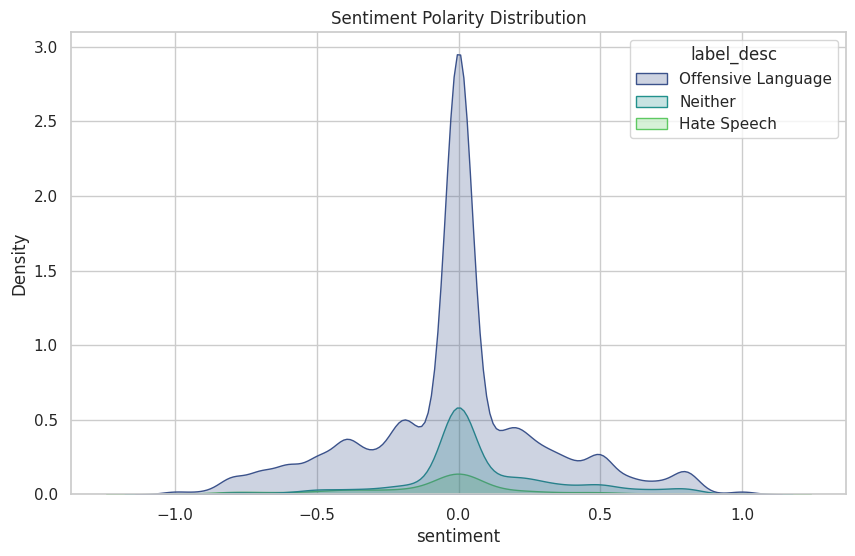

In [9]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='sentiment', hue='label_desc', fill=True, palette='viridis')
plt.title('Sentiment Polarity Distribution')
plt.show()

## Train baseline model: SVM

In [10]:
def stemming(text):
    tokens = text.split()
    processed_tokens = []
    for word in tokens:
        try:
            # Stemming reduces "running", "runs" -> "run", reducing vocab size
            stem = stemmer.stem(word)
            processed_tokens.append(stem)
        except:
            processed_tokens.append(word)
    return " ".join(processed_tokens)
df['clean_text'] = df['clean_text'].apply(stemming)
df_test['clean_text'] = df['clean_text'].apply(stemming)
X = df['clean_text']
y = df['class']

X_test = df_test['clean_text']
y_test = df_test['class']

param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

# TF-IDF Vectorization
print("Vectorizing...")
tfidf = TfidfVectorizer(max_features=2000) 
X = tfidf.fit_transform(df['clean_text'])
y = df['class']

# SVM Model Training
print("Training SVM...")
svm = SVC(random_state=42)
# Split Data (80% Train, 20% Test)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           cv=5, verbose=2, n_jobs=-1, scoring='f1_macro')

# Predictions & Evaluation
print("Starting Grid Search... (This may take a while)")
grid_search.fit(X, y)

# --- 5. Results ---
print("\nResults:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

X_test_tfidf = tfidf.transform(df_test['clean_text'])
y_test_pred = grid_search.predict(X_test_tfidf)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Hate Speech', 'Offensive Language', 'Neither']))

Vectorizing...
Training SVM...
Starting Grid Search... (This may take a while)
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Results:
Best Parameters: {'C': 10, 'kernel': 'linear'}
Best Cross-Validation Score: 0.7060

Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       0.04      0.03      0.04       286
Offensive Language       0.78      0.79      0.78      3838
           Neither       0.18      0.19      0.19       833

          accuracy                           0.64      4957
         macro avg       0.33      0.34      0.34      4957
      weighted avg       0.64      0.64      0.64      4957



In [11]:
df = pd.DataFrame(grid_search.cv_results_)
print(df[['params', 'mean_test_score', 'std_test_score']])
df.sort_values('mean_test_score', ascending=False)
df.head(10)

                              params  mean_test_score  std_test_score
0    {'C': 0.01, 'kernel': 'linear'}         0.290939        0.000021
1      {'C': 0.01, 'kernel': 'poly'}         0.290939        0.000021
2       {'C': 0.01, 'kernel': 'rbf'}         0.290939        0.000021
3   {'C': 0.01, 'kernel': 'sigmoid'}         0.290939        0.000021
4     {'C': 0.1, 'kernel': 'linear'}         0.561366        0.008456
5       {'C': 0.1, 'kernel': 'poly'}         0.306327        0.002009
6        {'C': 0.1, 'kernel': 'rbf'}         0.412789        0.005953
7    {'C': 0.1, 'kernel': 'sigmoid'}         0.558024        0.009400
8     {'C': 0.5, 'kernel': 'linear'}         0.644481        0.012655
9       {'C': 0.5, 'kernel': 'poly'}         0.398116        0.005542
10       {'C': 0.5, 'kernel': 'rbf'}         0.618104        0.007043
11   {'C': 0.5, 'kernel': 'sigmoid'}         0.634394        0.010550
12      {'C': 1, 'kernel': 'linear'}         0.689245        0.012142
13        {'C': 1, '

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,9.341630,0.126339,1.721535,0.006379,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.290938,0.290980,0.290926,0.290926,0.290926,0.290939,0.000021,21
1,26.957013,0.156227,3.230356,0.005631,0.01,poly,"{'C': 0.01, 'kernel': 'poly'}",0.290938,0.290980,0.290926,0.290926,0.290926,0.290939,0.000021,21
2,12.479787,0.057041,2.380477,0.020256,0.01,rbf,"{'C': 0.01, 'kernel': 'rbf'}",0.290938,0.290980,0.290926,0.290926,0.290926,0.290939,0.000021,21
3,9.531822,0.091936,1.845016,0.010390,0.01,sigmoid,"{'C': 0.01, 'kernel': 'sigmoid'}",0.290938,0.290980,0.290926,0.290926,0.290926,0.290939,0.000021,21
4,8.582229,0.074086,1.600296,0.008251,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.569236,0.545431,0.561021,0.563812,0.567328,0.561366,0.008456,13
5,44.469160,0.160161,3.374388,0.007323,0.1,poly,"{'C': 0.1, 'kernel': 'poly'}",0.304024,0.304233,0.306252,0.309058,0.308069,0.306327,0.002009,20
6,13.482273,0.172174,2.493988,0.025607,0.1,rbf,"{'C': 0.1, 'kernel': 'rbf'}",0.422121,0.409281,0.411818,0.404659,0.416067,0.412789,0.005953,18
7,9.076292,0.058987,1.686547,0.013234,0.1,sigmoid,"{'C': 0.1, 'kernel': 'sigmoid'}",0.565156,0.540822,0.558042,0.558329,0.567770,0.558024,0.009400,14
8,7.023556,0.064929,1.312655,0.016186,0.5,linear,"{'C': 0.5, 'kernel': 'linear'}",0.630056,0.667761,0.643447,0.637478,0.643663,0.644481,0.012655,10
9,53.646009,0.414411,3.397720,0.025691,0.5,poly,"{'C': 0.5, 'kernel': 'poly'}",0.398120,0.400007,0.402476,0.387524,0.402452,0.398116,0.005542,19


In [12]:
import joblib

best_svm_model = grid_search.best_estimator_

# 2. Save the Model and the Vectorizer
print("Saving model and vectorizer...")
joblib.dump(best_svm_model, 'best_svm_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl') # 'tfidf' is your fitted TfidfVectorizer variable

print("Model and vectorizer saved successfully!")

Saving model and vectorizer...
Model and vectorizer saved successfully!


In [13]:
# --- 2. Load Resources ---
print("Loading model and vectorizer...")
loaded_model = joblib.load('best_svm_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# X_test_tfidf_reload = loaded_vectorizer.transform(X_test)
# y_pred_reload = svm_model.predict(X_test_tfidf_reload)
# print("\nModel Evaluation:")
# print(f"Accuracy: {accuracy_score(y_test, y_pred_reload):.4f}")
# print("\nClassification Report:\n")
# print(classification_report(y_test, y_pred_reload, target_names=['Hate Speech', 'Offensive Language', 'Neither']))

Loading model and vectorizer...
